# Face identification

## InceptionResnetV1 on VGGFace 2 dataset

Using the pretrained model InceptionResnetV1 on VGGFace 2

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1

In [2]:
mtcnn_model = MTCNN(keep_all = True)
resnet_model = InceptionResnetV1(pretrained = 'vggface2').eval().to('cuda')

c:\Users\adhtr\scoop\apps\python39\3.9.13\lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_d

In [3]:
def plot_pictures(pictures: list[np.ndarray], titles: list[str] = None) -> tuple[plt.Figure, np.ndarray]:
    '''
    Adaptively compute number of rows and columns for given list of images
    and plot them with given titles.
    '''
    n = len(pictures)

    if titles is None:
        titles = [''] * n

    rows = int(np.sqrt(n))
    cols = int(np.ceil(n / rows))
    fig, axs = plt.subplots(rows, cols)

    if n == 1: axs = np.array([axs])
    axs = axs.flatten()

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j

            if idx < n:
                axs[idx].imshow(cv2.cvtColor(pictures[idx], cv2.COLOR_BGR2RGB))
                axs[idx].set_title(titles[idx])
                axs[idx].axis('off')
            else:
                axs[idx].axis('off')
                axs[idx].set_visible(False)

    return fig, axs

In [4]:
img = cv2.imread('data/template.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = mtcnn_model(img, return_prob = False)
template_faces = [face for face in faces]

### The algorithm to match faces

1. Collect all the faces from template images
2. For the given list of images/directories, detect all the faces in each image.
3. Independently search if for every face in template iamges, wether there is a match in the search image or not.
4. Output all the images that have a match.

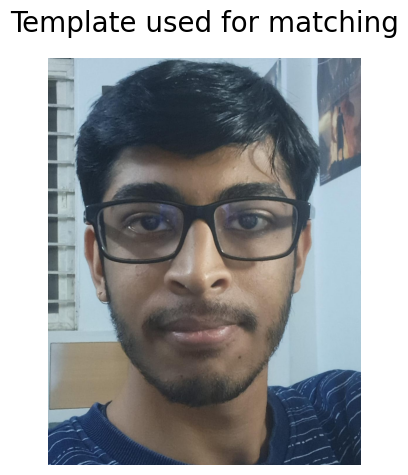

In [5]:
face_imgs = []

img = cv2.imread('data/template.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = mtcnn_model.detect(img_rgb)

for face in faces[0]:
    (x0, y0, x1, y1) = map(int, face)
    x0 -= max(0, int((x1 - x0) * .2))
    x1 += int((x1 - x0) * .2)
    y0 -= max(0, int((y1 - y0) * .2))
    y1 += int((y1 - y0) * .2)
    face_imgs.append(img[y0:y1, x0:x1])

fig = plot_pictures(face_imgs)[0]
fig.suptitle('Template used for matching', fontsize = 20)
fig.tight_layout();

In [6]:
import os

images_dataset = []
face_imgs = []

for img in os.listdir('data/test_faces/'):
    img = cv2.imread('data/test_faces/' + img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn_model(img_rgb, return_prob = False)
    if faces is None:
        continue
    images_dataset.extend([img for _ in faces])
    face_imgs.extend([face for face in faces])

print(len(face_imgs), 'faces detected')

9 faces detected


In [7]:
template_attached = torch.stack(template_faces).to('cuda')
template_embeddings = resnet_model(template_attached).detach().cpu().numpy()

print(len(template_embeddings[0]), 'features in embeddings')

512 features in embeddings


In [15]:
faces_attached = torch.stack(face_imgs).to('cuda')
faces_embeddings = resnet_model(faces_attached).detach().cpu().numpy()

print(len(faces_embeddings), 'face embeddings')

9 face embeddings


In [12]:
matched_images = []
matched_images_number = set()

for i in range(len(faces_embeddings)):
    for j in range(len(template_embeddings)):
        cross_norm = np.linalg.norm(faces_embeddings[i] - template_embeddings[j])
        if cross_norm < 0.8 and i not in matched_images_number:
            matched_images.append(images_dataset[i])
            matched_images_number.add(i)

### Results

1. Images where face is partly occluded are matched properly
2. Images subject is wearing a headphone is matched
3. Subject's no beard or more beard are matched
4. Images with side profile matched

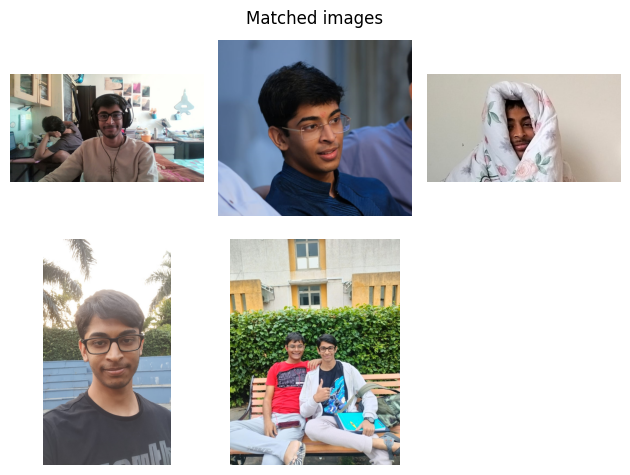

In [13]:
fig, axes = plot_pictures(list(matched_images))
fig.tight_layout()
fig.suptitle('Matched images');